<img src="https://user-images.githubusercontent.com/17668390/149876687-2f9796c5-c7ff-4558-9d40-aef635ead43b.png" width="600" height="600" />

# Abstraction 

- Dataset: [Bengali.AI Handwritten Grapheme Classification](https://www.kaggle.com/c/bengaliai-cv19)
- Task: **Multi-TasK and Multi-Class Classification**. 

In [1]:
# general packages
import os
import cv2
import gc
import math
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

#sklearns 
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.model_selection import train_test_split 

# keras modules 
import tensorflow as tf
import keras
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.optimizers import Adam, Nadam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, GlobalMaxPooling2D, concatenate
from keras.layers import (MaxPooling2D, Input, Average, Activation, MaxPool2D,
                          Flatten, LeakyReLU, BatchNormalization)
from keras import models
from keras import layers
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras.utils import Sequence
from keras import utils as np_utils
from keras.callbacks import (Callback, ModelCheckpoint,
                                        LearningRateScheduler,EarlyStopping, 
                                        ReduceLROnPlateau,CSVLogger)

warnings.simplefilter('ignore')
sns.set_style('whitegrid')

Using TensorFlow backend.


In [2]:
# declare some parameter
SEED       = 2020
batch_size = 12 
dim        = (128, 128)
SIZE       = 128
stats      = (0.0692, 0.2051)
HEIGHT     = 137 
WIDTH      = 236

def seed_all(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    
# seed all
seed_all(SEED)

# load files
im_path = '../input/grapheme-imgs-128x128/'
train   = pd.read_csv('../input/bengaliai-cv19/train.csv')
test    = pd.read_csv('../input/bengaliai-cv19/test.csv')

train = train.sample(frac=1).reset_index(drop=True) # shuffling 
train['filename'] = train.image_id.apply(lambda filename: im_path + filename + '.png')

# top 5 samples
train.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,filename
0,Train_145648,81,6,0,নৃ,../input/grapheme-imgs-128x128/Train_145648.png
1,Train_24895,125,7,0,ল্কে,../input/grapheme-imgs-128x128/Train_24895.png
2,Train_75994,59,7,0,ণে,../input/grapheme-imgs-128x128/Train_75994.png
3,Train_442,43,0,4,জ্য,../input/grapheme-imgs-128x128/Train_442.png
4,Train_177898,13,9,2,র্কো,../input/grapheme-imgs-128x128/Train_177898.png


# Data Augmentation  
We will be using following two augmentation method. The program will choose randomly one of them while training. 

- [GridMask](https://arxiv.org/abs/2001.04086): It utilizes information removal to achieve state-of-the-art results in a variety of computer vision tasks. It is based on the deletion of regions of the input image.
- [AugMix](https://arxiv.org/abs/1912.02781): A data processing technique that is simple to implement, adds limited computational overhead, and helps models withstand unforeseen corruptions. 

### GridMask From [Qishen Ha](https://www.kaggle.com/haqishen/gridmask) 

In [3]:
## Grid Mask
# code takesn from https://www.kaggle.com/haqishen/gridmask
import albumentations
from albumentations.core.transforms_interface import DualTransform, ImageOnlyTransform
from albumentations.augmentations import functional as F

class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [4]:
# augmix : https://github.com/google-research/augmix

from PIL import Image
from PIL import ImageOps
import numpy as np

def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.

def sample_level(n):
    return np.random.uniform(low=0.1, high=n)

def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)

def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)

def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)

def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)

def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)

def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform((SIZE, SIZE),
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)

def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform((SIZE, SIZE),
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)

def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), SIZE / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform((SIZE, SIZE),
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), SIZE / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform((SIZE, SIZE),
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)

augmentations = [
    autocontrast, 
    equalize,
    posterize,
    rotate,
    solarize, 
    shear_x, 
    shear_y,
    translate_x,
    translate_y
]

# taken from https://www.kaggle.com/iafoss/image-preprocessing-128x128
MEAN = [ 0.06922848809290576,  0.06922848809290576,  0.06922848809290576]
STD  = [ 0.20515700083327537,  0.20515700083327537,  0.20515700083327537]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    image = image.transpose(2, 0, 1)  # Switch to channel-first
    mean, std = np.array(MEAN), np.array(STD)
    image = (image - mean[:, None, None]) / std[:, None, None]
    return image.transpose(1, 2, 0)


def apply_op(image, op, severity):
    image = np.clip(image * 255., 0, 255).astype(np.uint8)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img) / 255.


def augment_and_mix(image, severity=1, width=3, depth=1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
  """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        mix = np.add(mix, ws[i] * normalize(image_aug), out=mix, 
                     casting="unsafe")

    mixed = (1 - m) * normalize(image) + m * mix
    return mixed

# Grapheme Data Generator

In [5]:
class GraphemeGenerator(keras.utils.Sequence):
    def __init__(self, data, batch_size, dim, shuffle=True, transform=None):
        self._data = data
        self._label_1 = pd.get_dummies(self._data['grapheme_root'], 
                                       columns = ['grapheme_root'])
        self._label_2 = pd.get_dummies(self._data['vowel_diacritic'], 
                                       columns = ['vowel_diacritic'])
        self._label_3 = pd.get_dummies(self._data['consonant_diacritic'], 
                                       columns = ['consonant_diacritic'])
        self._list_idx = data.index.values
        self._batch_size = batch_size
        self._dim = dim
        self._shuffle = shuffle
        self.transform = transform
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self._data)/self._batch_size))
    
    def __getitem__(self, index):
        batch_idx = self._indices[index*self._batch_size:(index+1)*self._batch_size]
        _idx = [self._list_idx[k] for k in batch_idx]

        Data     = np.empty((self._batch_size, *self._dim, 1))
        Target_1 = np.empty((self._batch_size, 168), dtype = int)
        Target_2 = np.empty((self._batch_size, 11 ), dtype = int)
        Target_3 = np.empty((self._batch_size,  7 ), dtype = int)
        
        for i, k in enumerate(_idx):
            # load the image file using cv2
            image = cv2.imread(im_path + self._data['image_id'][k] + '.png')
            image = cv2.resize(image,  self._dim) 
            
            if self.transform is not None:
                if np.random.rand() > 0.7:
                    # albumentation : grid mask
                    res = self.transform(image=image)
                    image = res['image']
                else:
                    # augmix augmentation
                    image = augment_and_mix(image)
            
            # scaling 
            image = (image.astype(np.float32)/255.0 - stats[0])/stats[1]
            
            # gray scaling 
            gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
            image = gray(image)  
            
            # expand the axises 
            image = image[:, :, np.newaxis]
            Data[i,:, :, :] =  image
        
            Target_1[i,:] = self._label_1.loc[k, :].values
            Target_2[i,:] = self._label_2.loc[k, :].values
            Target_3[i,:] = self._label_3.loc[k, :].values
            
        return Data, [Target_1, Target_2, Target_3]
    
    
    def on_epoch_end(self):
        self._indices = np.arange(len(self._list_idx))
        if self._shuffle:
            np.random.shuffle(self._indices)

# Modeling

In [8]:
!pip install ../input/efficientnet-keras-source-code/ -q

Processing /kaggle/input/efficientnet-keras-source-code
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp36-none-any.whl size=18435 sha256=4d051aab4668a470edf460020335885329f774df76e576545fe9d3ac9716c8df
  Stored in directory: /root/.cache/pip/wheels/89/09/2c/ea93c476dd70c213dee8b7b52f4069b796f7dc59c8bc9f3e07
Successfully built efficientnet


In [9]:
import efficientnet.keras as efn 

# we will be using EfficientNetB0
wg = '../input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5'
efnet = efn.EfficientNetB0(weights=wg, 
                           include_top = False, 
                           input_shape=(128, 128, 3))

## Group Normalization

BN's error increases rapidly when the batch size becomes smaller, caused by inaccurate batch statistics estimation. [Group Normalization](https://arxiv.org/pdf/1803.08494.pdf) (GN) as a simple alternative to BN. GN divides the channels into groups and computes within each group the mean and variance for normalization. GN's computation is independent of batch sizes, and its accuracy is stable in a wide range of batch sizes.

Code from [Somshubra Majumdar](https://github.com/titu1994/Keras-Group-Normalization) 

In [10]:
from keras.engine import Layer

class GroupNormalization(Layer):
    """Group normalization layer
    Group Normalization divides the channels into groups and computes within each group
    the mean and variance for normalization. GN's computation is independent of batch sizes,
    and its accuracy is stable in a wide range of batch sizes
    # Arguments
        groups: Integer, the number of groups for Group Normalization.
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shap

In [11]:
# Replace all Batch Normalization layers by Group Normalization layers
for i, layer in enumerate(efnet.layers):
    if "batch_normalization" in layer.name:
        efnet.layers[i] = GroupNormalization(groups=32, 
                                             axis=-1, 
                                             epsilon=0.00001)

### Complete Model

In [12]:
def E0(input_dim, output_dim, base_model):
    
    input_tensor = Input(input_dim)
    
    x = Conv2D(3, (3, 3), padding='same',  kernel_initializer='he_uniform', 
               bias_initializer='zeros')(input_tensor)
    curr_output = base_model(x)
    curr_output = GlobalAveragePooling2D()(curr_output)
    curr_output = Dropout(0.5)(curr_output)
    curr_output = Dense(512, activation='elu')(curr_output)
    curr_output = Dropout(0.5)(curr_output)
        
    oputput1 = Dense(168,  activation='softmax', name='gra') (curr_output)
    oputput2 = Dense(11,  activation='softmax', name='vow') (curr_output)
    oputput3 = Dense(7,  activation='softmax', name='cons') (curr_output)
    output_tensor = [oputput1, oputput2, oputput3]

    model = Model(input_tensor, output_tensor)
    
    return model

# building the complete model
model_E0 = E0(input_dim=(128,128,1),
                     output_dim=(168,11,7), base_model = efnet)

In [13]:
def D169(input_dim, output_dim, base_model):
    
    input_tensor = Input(input_dim)
    
    x = Conv2D(3, (3, 3), padding='same',  kernel_initializer='he_uniform', 
               bias_initializer='zeros')(input_tensor)
    curr_output = base_model(x)
    curr_output = BatchNormalization()(curr_output)
    curr_output = GlobalAveragePooling2D()(curr_output)
    curr_output = Dense(512, activation='relu')(curr_output)
    curr_output = Dropout(0.5)(curr_output)
    curr_output = Dense(1024, activation='relu')(curr_output)
    
    oputput1 = Dense(168,  activation='softmax', name='gra') (curr_output)
    oputput2 = Dense(11,  activation='softmax', name='vow') (curr_output)
    oputput3 = Dense(7,  activation='softmax', name='cons') (curr_output)
    
    output_tensor = [oputput1, oputput2, oputput3]
    
    model = Model(input_tensor, output_tensor)
    
    return model

# define next model
densenet = DenseNet169(include_top=False, weights=None,
                       input_shape=(128, 128, 3))

model_D169 = D169(input_dim=(128,128,1),
                     output_dim=(168,11,7), base_model = densenet)

### Optimizer 
For the Optmizer, we will be using **AdaBound**. It trains as fast as Adam and as good as SGD, for developing state-of-the-art deep learning models on a wide variety of popular tasks in the field of CV, NLP, and etc.

Read More: [Paper](https://arxiv.org/abs/1902.09843) | [Code](https://github.com/titu1994/keras-adabound) 

In [14]:
# code: https://github.com/titu1994/keras-adabound   
class AdaBound(keras.optimizers.Optimizer):
    """AdaBound optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        final_lr: float >= 0. Final learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        gamma: float >= 0. Convergence speed of the bound function.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: Weight decay weight.
        amsbound: boolean. Whether to apply the AMSBound variant of this
            algorithm.
    # References
        - [Adaptive Gradient Methods with Dynamic Bound of Learning Rate]
          (https://openreview.net/forum?id=Bkg3g2R9FX)
        - [Adam - A Method for Stochastic Optimization]
          (https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond]
          (https://openreview.net/forum?id=ryQu7f-RZ)
    """

    def __init__(self, learning_rate=0.001, final_lr=0.1, beta_1=0.9, beta_2=0.999, gamma=1e-3,
                 epsilon=None, decay=0., amsbound=False, weight_decay=0.0, **kwargs):
        super(AdaBound, self).__init__(**kwargs)

        if not 0. <= gamma <= 1.:
            raise ValueError("Invalid `gamma` parameter. Must lie in [0, 1] range.")

        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learning_rate = K.variable(learning_rate, name='learning_rate')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')

        self.final_lr = final_lr
        self.gamma = gamma

        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsbound = amsbound

        self.weight_decay = float(weight_decay)
        self.base_lr = float(learning_rate)

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        learning_rate = self.learning_rate
        if self.initial_decay > 0:
            learning_rate = learning_rate * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        # Applies bounds on actual learning rate
        step_size = learning_rate * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                          (1. - K.pow(self.beta_1, t)))

        final_lr = self.final_lr * learning_rate / self.base_lr
        lower_bound = final_lr * (1. - 1. / (self.gamma * t + 1.))
        upper_bound = final_lr * (1. + 1. / (self.gamma * t))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsbound:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            # apply weight decay
            if self.weight_decay != 0.:
                g += self.weight_decay * K.stop_gradient(p)

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            if self.amsbound:
                vhat_t = K.maximum(vhat, v_t)
                denom = (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                denom = (K.sqrt(v_t) + self.epsilon)

            # Compute the bounds
            step_size_p = step_size * K.ones_like(denom)
            step_size_p_bound = step_size_p / denom
            bounded_lr_t = m_t * K.minimum(K.maximum(step_size_p_bound,
                                                     lower_bound), upper_bound)

            p_t = p - bounded_lr_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'learning_rate': float(K.get_value(self.learning_rate)),
                  'final_lr': float(self.final_lr),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'gamma': float(self.gamma),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay,
                  'amsbound': self.amsbound}
        base_config = super(AdaBound, self).get_config()
        return dict(list(base_config.items()) + list(config.items())) 

**Compiling**

In [15]:
from keras import backend as K

for model in [model_E0, model_D169]:
    # compiling    
    model.compile(

        optimizer = AdaBound(learning_rate=0.001,
                        final_lr=.1,
                        gamma=1e-3,
                        weight_decay=5e-4,
                        amsbound=False), 

        loss = {'gra' : 'categorical_crossentropy', 
                'vow' : 'categorical_crossentropy', 
                'cons': 'categorical_crossentropy'},

        loss_weights = {'gra' : 1.0,
                        'vow' : 1.0,
                        'cons': 1.0},

        metrics={'gra' : 'accuracy', 
                 'vow' : 'accuracy', 
                 'cons': 'accuracy'}
    )


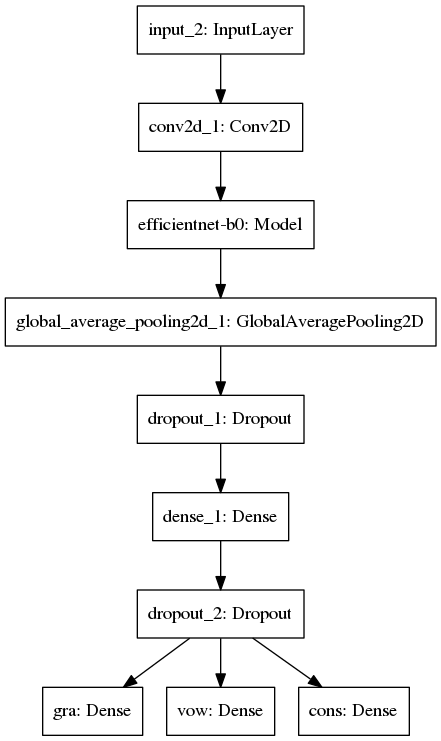

In [16]:
# visualize the model layouts
from keras.utils import plot_model

plot_model(model_E0, to_file='model.png')

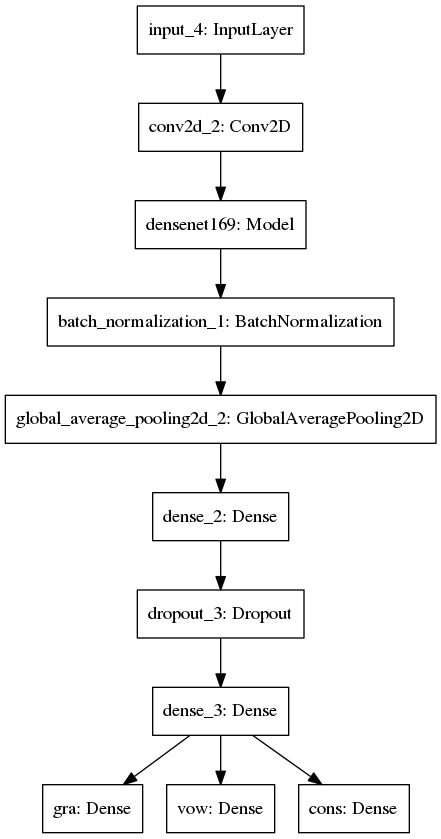

In [17]:
plot_model(model_D169, to_file='model.png') 

## Generating Training Set and Validation Set

Here we will use **GridMask** and **AugMix** augmentation on the data set randomly. In GridMask, we can pass various argument to get various type of augmentation results. Please, visit to [this](https://www.kaggle.com/haqishen/gridmask) kernel for more detials. I stick with the simplest form. 

In [18]:
# grid mask augmentation
transforms_train = albumentations.Compose([
    GridMask(num_grid=3, rotate=15, p=1),
])

# for way one - data generator
train_labels, val_labels = train_test_split(train, test_size = 0.10, random_state = SEED,
                                            stratify = train[['grapheme_root', 
                                                              'vowel_diacritic', 
                                                              'consonant_diacritic']])

# training generator
train_generator = GraphemeGenerator(train_labels, batch_size, dim, 
                                shuffle = True, transform=None)

# validation generator: no shuffle , not augmentation
val_generator = GraphemeGenerator(val_labels, batch_size, dim, 
                              shuffle = False)

In [19]:
for i, item in enumerate(train_generator):
    x,y = item
    print(x.shape)
    if i == 0: break

(12, 128, 128, 1)


## Visualize the training samples 

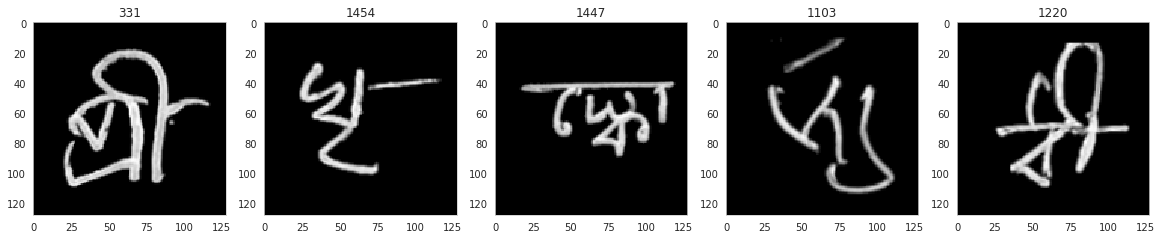

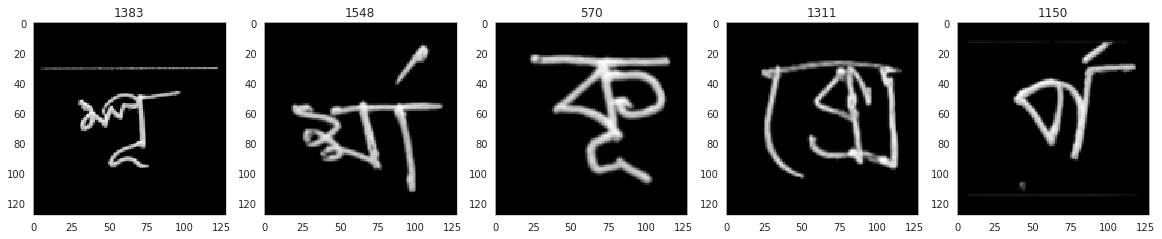

In [20]:
from pylab import rcParams

# helper function to plot sample 
def plot_imgs(dataset_show):
    '''
    code: <plot_imgs> method from - https://www.kaggle.com/haqishen/gridmask
    '''
    rcParams['figure.figsize'] = 20,10
    for i in range(2):
        f, ax = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(dataset_show))
            img, label = dataset_show[idx]
            ax[p].grid(False)
            ax[p].imshow(img[0][:,:,0], cmap=plt.get_cmap('gray'))
            ax[p].set_title(idx)

# calling the above function           
plot_imgs(val_generator)   # non-augmented   

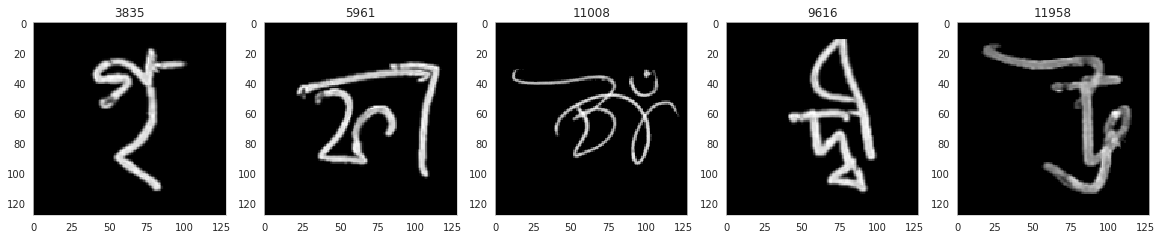

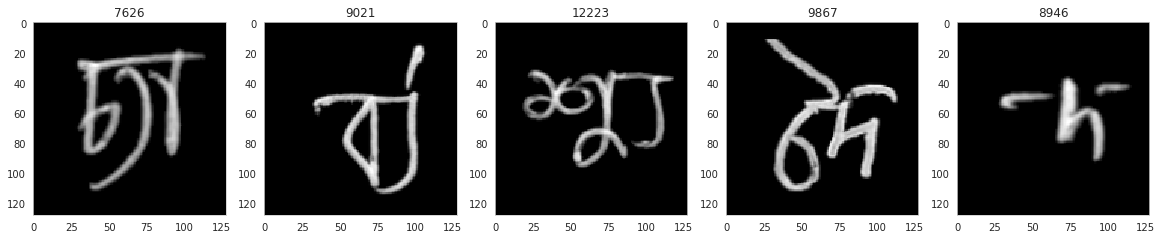

In [21]:
plot_imgs(train_generator) # augmented 

In [22]:
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger)

# some call back function; feel free to add more for experiment
def Call_Back():
    # model check point
    checkpoint = ModelCheckpoint('E0Train_B0.h5', 
                                 monitor = 'val_loss', 
                                 verbose = 0, save_best_only=True, 
                                 mode = 'min',
                                 save_weights_only = True)
    
    csv_logger = CSVLogger('E0.csv')
    early = EarlyStopping(monitor='val_loss', 
                          mode='min', patience=5)
    
    return [checkpoint, csv_logger, early]

# epoch size 
epochs = 60 # increase the number, ex.: 100/200
training = False # setting it true for training the model

# calling all callbacks 
callbacks = Call_Back()

if training:
    # acatual training (fitting)
    train_history = model.fit_generator(
        train_generator,
        steps_per_epoch=int(len(train_labels)/batch_size), 
        validation_data=val_generator,
        validation_steps = int(len(val_labels)/batch_size),
        epochs=epochs,
        callbacks=callbacks
    )
else: 
    model_E0.load_weights('../input/0909e0/0.909.h5')
    model_D169.load_weights('../input/newdensenet/newde69.h5')

# Prediction 

In [23]:
# helper function
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    
    return cv2.resize(img,(size,size))

In [24]:
# Test data generator
def test_batch_generator(df, batch_size):
    num_imgs = len(df)

    for batch_start in range(0, num_imgs, batch_size):
        curr_batch_size = min(num_imgs, batch_start + batch_size) - batch_start
        idx = np.arange(batch_start, batch_start + curr_batch_size)

        names_batch = df.iloc[idx, 0].values
        imgs_batch = 255 - df.iloc[idx, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
        X_batch = np.zeros((curr_batch_size, SIZE, SIZE, 1))
        
        for j in range(curr_batch_size):
            img = (imgs_batch[j,]*(255.0/imgs_batch[j,].max())).astype(np.uint8)
            img = crop_resize(img, size=SIZE)
            img = (img.astype(np.float32)/255.0 - stats[0])/stats[1]
            img = img[:, :, np.newaxis]
            X_batch[j,] = img

        yield X_batch, names_batch


# load the parquet files 
TEST = [
    "../input/bengaliai-cv19/test_image_data_0.parquet",
    "../input/bengaliai-cv19/test_image_data_1.parquet",
    "../input/bengaliai-cv19/test_image_data_2.parquet",
    "../input/bengaliai-cv19/test_image_data_3.parquet",
]

# placeholders 
row_id = []
target = []

# iterative over the test sets
for fname in tqdm(TEST):
    test_ = pd.read_parquet(fname)
    test_gen = test_batch_generator(test_, batch_size=batch_size)

    for batch_x, batch_name in test_gen:
        # prediction
        batch_predict_1 = model_E0.predict(batch_x, batch_size = 128)
        batch_predict_2 = model_D169.predict(batch_x, batch_size = 128)
 
        for idx, name in enumerate(batch_name):
            row_id += [
                f"{name}_consonant_diacritic",
                f"{name}_grapheme_root",
                f"{name}_vowel_diacritic",
            ]
            target += [
                np.argmax((batch_predict_1[2] + batch_predict_2[2])/2, axis=1)[idx],
                np.argmax((batch_predict_1[0] + batch_predict_2[0])/2, axis=1)[idx],
                np.argmax((batch_predict_1[1] + batch_predict_2[1])/2, axis=1)[idx],
            ]

    del test_
    gc.collect()
    
    
df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)

df_sample.to_csv('submission.csv',index=False)
gc.collect()

3

In [25]:
df_sample

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
5,Test_1_vowel_diacritic,2
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,19
8,Test_2_vowel_diacritic,0
9,Test_3_consonant_diacritic,0


That's it. Feel free to experiment on various stuff, like model architecture, image size, augmentation methods etc. You might want to train longer and tweak the parameters. However, here are some my experimental observation, hope it may give you some insight.

```
> Exp1 | LB: 0.9410
input     : 100 px, batch size : 32, split: 80/20
model     : EfficientB4 + BN + GAP + Dropout
optimizer : Adam(1e-3)
epoch     : 20
data-aug  : False

> Exp2 | LB: 0.9470
input     : 125 px, batch size : 32, split: 80/20
model     : EfficientB0 + Group Normalization + GAP + Dropout
optimizer : AdaBound(1e-3)
epoch     : 20
data-aug  : AugMix

> Exp3 | LB: 0.9497
input     : 138 px, batch size : 32, split: 80/20
model     : DenseNet121 + Filter Response Normalization + GAP + Dropout 
sched     : WarmUpCosineDecayScheduler
optimizer : Adam(1e-3)
epoch     : 40
data-aug  : AugMix + CutOut

> Exp4 | LB: 0.9535
input     : 128 px, batch size : 32, split: 80/20
model     : EfficientB5 + BN + GAP + Dropout
optimizer : AdaBound(1e-3)
epoch     : 30
data-aug  : AugMix + GridMask

> Exp5 | LB: 0.9620
input     : 150 px, batch size : 40, split: 80/20 (stratify)
model     : EfficientB5 + BN + [GAP + GMP] + BN + Dense + Dropout
optimizer : Adam(1e-3)
epoch     : 60
data-aug  : AugMix + GridMask (70%)
```